# Employee scheduling


pyschedule can be used for employee scheduling. The following example is motivated by instances from:

http://www.cs.nott.ac.uk/~tec/NRP/#new_instances

We simplified these instances a little bit for the sake of exposition. First load some instance:

In [3]:
employee_names = ['A','B','C','D','E','F','G','H']
n_days = 14 # number of days
days = list(range(n_days))

max_seq = 5 # max number of consecutive shifts
min_seq = 2 # min sequence without gaps
max_work = 10 # max total number of shifts
min_work = 7 # min total number of shifts
max_weekend = 3 # max number of weekend shifts

# number of required shifts for each day
shift_requirements =\
{
0: 5,
1: 7,
2: 6,
3: 4,
4: 5,
5: 5,
6: 5,
7: 6,
8: 7,
9: 4,
10: 2,
11: 5,
12: 6,
13: 4
}

# specific shift requests by employees for days
shift_requests =\
[
('A',0),
('B',5),
('C',8),
('D',2),
('E',9),
('F',5),
('G',1),
('H',7),
('A',3),
('B',4),
('C',4),
('D',9),
('F',1),
('F',2),
('F',3),
('F',5),
('F',7),
('H',13)
]


# Solving without shift requests

First build the scenario without any shift requests:

INFO: execution time for solving mip (sec) = 19.21512198448181
INFO: objective = 0.0


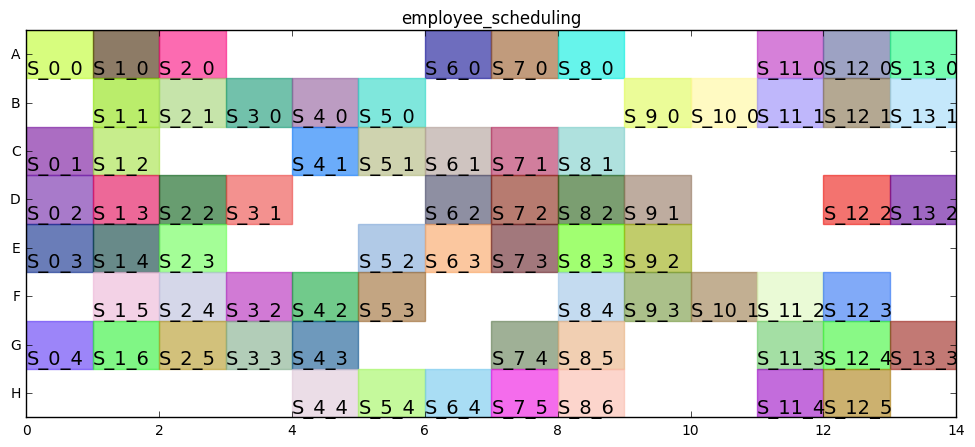

In [4]:

from pyschedule import Scenario, solvers, plotters, alt

# Create employee scheduling scenari
S = Scenario('employee_scheduling',horizon=n_days)

# Create enployees as resources indexed by namesc
employees = { name : S.Resource(name) for name in employee_names }

# Create shifts as tasks
shifts = { (day,i) : S.Task('S_%s_%s'%(str(day),str(i))) 
          for day in shift_requirements if day in days
          for i in range(shift_requirements[day]) }

# distribute shifts to days
for day,i in shifts:
    # Assign shift to its day
    S += shifts[day,i] >= day
    # The shifts on each day are interchangeable, so add them to the same group
    shifts[day,i].group = day
    # Weekend shifts get attribute week_end
    if day % 7 in {5,6}:
        shifts[day,i].week_end = 1

# There are no restrictions, any shift can be done by any employee
for day,i in shifts:
    shifts[day,i] += alt( S.resources() )
    
# Capacity restrictions
for name in employees:
    # Maximal number of shifts
    S += employees[name] <= max_work
    # Minimal number of shifts
    S += employees[name] >= min_work
    # Maximal number of weekend shifts using attribute week_end
    S += employees[name]['week_end'] <= max_weekend

# Max number of consecutive shifts
for name in employees:
    for day in range(n_days):
        S += employees[name][day:day+max_seq+1] <= max_seq

# Min sequence without gaps
for name in employees:
    # No increase in last periods
    S += employees[name][n_days-min_seq:].inc <= 0
    # No decrease in first periods
    S += employees[name][:min_seq].dec <= 0
    # No diff during time horizon
    for day in days[:-min_seq]:
        S += employees[name][day:day+min_seq+1].diff <= 1
        
# Solve and plot scenario
if solvers.mip.solve(S,kind='CBC',msg=1,random_seed=6):
    %matplotlib inline
    plotters.matplotlib.plot(S,fig_size=(12,5))
else:
    print('no solution found')


# Solving with shift requests

To include shift requests, we use the following heuristic: iteratively add requests in the given order. If one shift request does not fit, remove it again and proceed with the next one. In case CBC get stuck repeat each computation several times with some random seed:

A 0 compute time: 3.3704609870910645
B 5 compute time: 3.3509323596954346
C 8 compute time: 2.053898572921753
D 2 compute time: 2.506223678588867
E 9 compute time: 2.9735267162323
F 5 compute time: 2.2651009559631348
G 1 compute time: 1.9516406059265137
H 7 compute time: 2.5153496265411377
A 3 compute time: 3.3906898498535156
B 4 compute time: 1.9036805629730225
C 4 compute time: 2.03175950050354
D 9 compute time: 2.7574009895324707
F 1 compute time: 2.387035369873047
F 2 compute time: 1.8204820156097412
F 3 compute time: 1.143928050994873
F 5 compute time: 1.0613789558410645
F 7 compute time: 1.0182976722717285
cant fit last shift request
H 13 compute time: 1.0950939655303955


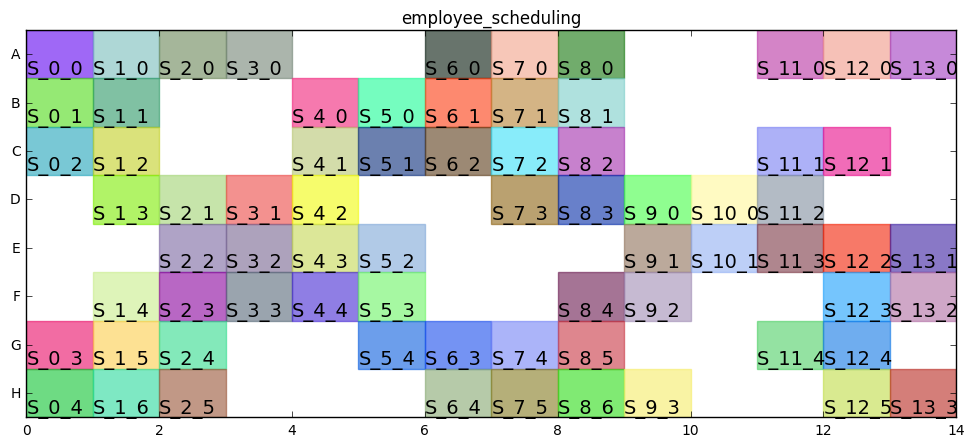

In [5]:

import random
import time

time_limit = 10 # time limit for each run
repeats = 5 # repeated random runs because CBC might get stuck

# Iteratively add shift requests until no solution exists
for name,day in shift_requests:
    S += employees[name][day] >= 1
    for i in range(repeats):
        random_seed = random.randint(0,10000)
        start_time = time.time()
        status = solvers.mip.solve(S,kind='CBC',time_limit=time_limit,
                                   random_seed=random_seed,msg=0)
        # Break when solution found
        if status:
            break
    print(name,day,'compute time:', time.time()-start_time)
    # Break if all computed solution runs fail
    if not status:
        S -= employees[name][day] >= 1
        print('cant fit last shift request')

# Plot the last computed solution
%matplotlib inline
plotters.matplotlib.plot(S,fig_size=(12,5))
